# Lab 4. Tensorflow models 2 (CNN and RNN)

In this lab, we will continue to investigate CNN and also try making a new RNN model on sequential datasets.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd

### Section 1: Larger and more complex image dataset / Tensorflow datasets

In Fashion MNIST classification, the subject is always in the ``center`` of a 28x28 image. This means the network only needs to get important features from a fixed area.

However, in this section, we will take it to the next level, training to recognize features in an image where the subject can be ``anywhere`` in the image - Building a ``horses-or-humans`` classifier that will tell you if a given image contains a horse or a human, where the network is trained to recognize features that determine which is which.


We first need to download the dataset. This time, we will use `tensorflow_datasets` module to download one of the famous datasets in this area. You can import it as below if you already have it. Note that this is not part of the `tensorflow` build so you may need to install it using pip.



In [ ]:
import tensorflow_datasets as tfds

You can check the catalog with `list_builders()` or on the [website](https://www.tensorflow.org/datasets/).

In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

Today we will use the **Horses or Humans** dataset... You can use `tfds.load` function to load a specific data in the catalog.

In [ ]:
# tfds.load
# - split [train, valid, test]
# - shuffle_files
# - as_supervised
# with_info
((train_ds, valid_ds, test_ds), info) = tfds.load('HorsesOrHumans', split=['train[:75%]', 'train[75%:]', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

In [ ]:
# Check the type of those three datasets
train_ds, valid_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

You can check the size by using `.cardinality()` since those are in the `tf.Data` format.

In [ ]:
train_ds.cardinality(), valid_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=770>,
 <tf.Tensor: shape=(), dtype=int64, numpy=257>,
 <tf.Tensor: shape=(), dtype=int64, numpy=256>)

If you set `with_info=True`, you can check some information of the dataset.

In [ ]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='/root/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

Some examples ...

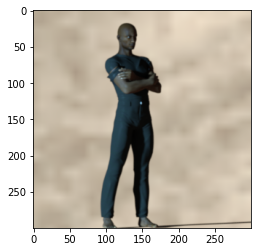

In [ ]:
sample = train_ds.take(1)
for example in sample:
  imgplot = plt.imshow(example[0])
  plt.show()

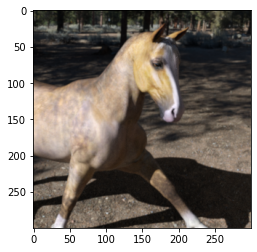

In [ ]:
sample = train_ds.take(1)
for example in sample:
  imgplot = plt.imshow(example[0])
  plt.show()

We can use `tf.Data` functions sich as `batch` and `prefetch` directly since those datasets are in tf.Data format.
 - [Prefetch and cache](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwim-q_1l4T9AhU0RvEDHUj1Cx4QtwJ6BAhEEAI&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DMLEKEplgCas&usg=AOvVaw2anFNZFGU675DMnyVTqDZ1)

In [ ]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

Now we can try making a CNN model. Let's make a bit deeper model than the one we created in the last lab. We should also not forget about **rescaling**, but this time we do this by creating a new layer called `Rescaling`.
 - [What is fully convolutional network?](https://ai.stackexchange.com/questions/21810/what-is-a-fully-convolution-network)

In [ ]:
#### CNN MODELS (Sequential) ####
# activation
# padding - same, valid
# pooling
# dropout

model = tf.keras.models.Sequential([
    # Another way of scaling the data (Rescaling(1./255, input_shape=(300, 300, 3)))
    tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),
    # The first convolution (Conv2D, 16, (3,3), relu) + MaxPooling2D
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution (32, (3,3))
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution (64)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution (64)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution (64)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # hidden layer with 512 neurons
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron with the sigmoid function. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can always check the parameter size of your model with `model.summary()`.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 64)       

Here we have a binary classification problem so we can set the binary cross-entropy loss function, and we can also specify any optimizer that we prefer.

In [ ]:
# Complie the model
# - loss = binary crossentropy
# - optimizer = RMSprop with learning rate 0.001
# - metrics = accuracy
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['acc'])

We can finally fit our model on the dataset. There can be different strategy for different method to create the dataset.

In [ ]:
# Fit the model (train_ds, valid_ds, 10 epochs)
history = model.fit(
      train_ds,
      validation_data = valid_ds,  
      epochs=10,
      verbose=1)

Epoch 1/10
25/25 [==============================] - 4s 128ms/step - loss: 0.6966 - acc: 0.5909 - val_loss: 0.7828 - val_acc: 0.6926
Epoch 2/10
25/25 [==============================] - 3s 123ms/step - loss: 0.4611 - acc: 0.8065 - val_loss: 0.1649 - val_acc: 0.9416
Epoch 3/10
25/25 [==============================] - 4s 148ms/step - loss: 0.2776 - acc: 0.8974 - val_loss: 0.2039 - val_acc: 0.9066
Epoch 4/10
25/25 [==============================] - 3s 126ms/step - loss: 0.1774 - acc: 0.9286 - val_loss: 0.0882 - val_acc: 0.9533
Epoch 5/10
25/25 [==============================] - 3s 121ms/step - loss: 0.1521 - acc: 0.9403 - val_loss: 0.0471 - val_acc: 0.9844
Epoch 6/10
25/25 [==============================] - 4s 142ms/step - loss: 0.1269 - acc: 0.9675 - val_loss: 0.8266 - val_acc: 0.7782
Epoch 7/10
25/25 [==============================] - 3s 120ms/step - loss: 0.1204 - acc: 0.9714 - val_loss: 0.0380 - val_acc: 0.9844
Epoch 8/10
25/25 [==============================] - 3s 119ms/step - loss: 0.

In [ ]:
# Evaluate the model on test_ds
model.evaluate(test_ds)

8/8 [==============================] - 1s 56ms/step - loss: 1.4139 - acc: 0.8672


[1.4138610363006592, 0.8671875]

### Section 2: Use a pretrained CNN model

Sometimes, especially when you have a big amount of data, you may not be able to get a good enough performance, and this happens most of the times when you work on the actual project. In this case, you can always use pretrained models available from Keras. Those networks are already trained on massive amount of the data so you can generally get better results after you tweak the model a bit and train it on your own problem.
- [List of pretrained models in keras.application](https://keras.io/api/applications/)

In [ ]:
# VGG network can be found from keras.applications
from keras.applications.vgg16 import VGG16

You can call the model by initializing the imported class (e.g., VGG16()).

In [ ]:
# Import the model by calling VGG16() and get the summary (model structure). Notice the input size.
model_vgg = VGG16()
model_vgg.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

We can change some part of this pretrained model to make it adjust to our dataset. Normally we change two parts:
 - Input layer
 - Output layer

The block below is calling the pretrained model but replacing the input layer. However, that is not always the case as we can also change our input to have the same shape by applying preprocessing method that the pretrained model has.

In [ ]:
# 'include_top' and 'input_tensor' are two main functions we need to change!
# For input_tensor, you specify keras' input layer (keras.layers.Input) with your iamge size
# We can also change the 'pooling' method for "output"
model_base = VGG16(include_top=False,
                   pooling='avg',
                   input_tensor=keras.layers.Input(shape=(300, 300, 3)))
model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

When we use a pretrained model, we normally make the model not trainable except for the first layer where we put our new images, and if the model does not have a fully connected layer, we can also put few more layers to return correct size output.

In [ ]:
def vgg():
  ############################
  # You need to freeze the pre-trained weights first time
  model_base.trainable = False
  ############################

  model = keras.Sequential([
      model_base,
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu', name='dense_1'),
      keras.layers.Dropout(0.5, name='drop_1'),
      keras.layers.Dense(64, activation='relu', name='dense_2'),
      keras.layers.Dropout(0.5, name='drop_2'),
      keras.layers.Dense(1, activation='sigmoid', name='output')
  ])

  model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
              metrics=['acc'])
  return model

We can define our compiled model and use the `EarlyStopping` callback.

In [ ]:
model_vgg = vgg()

# We can also have an early stopping callback
# - min_delta
# - patience
# - restore_best_weights

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

# When the model stop making any meaningful progress ...
history = model_vgg.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/5
25/25 [==============================] - 11s 386ms/step - loss: 3.1505 - acc: 0.8701 - val_loss: 0.0155 - val_acc: 0.9961
Epoch 2/5
25/25 [==============================] - 9s 371ms/step - loss: 0.0636 - acc: 0.9831 - val_loss: 2.3212e-04 - val_acc: 1.0000
Epoch 3/5
25/25 [==============================] - 9s 375ms/step - loss: 0.0310 - acc: 0.9896 - val_loss: 0.0184 - val_acc: 0.9961
Epoch 4/5
25/25 [==============================] - 10s 381ms/step - loss: 0.0812 - acc: 0.9857 - val_loss: 0.0035 - val_acc: 0.9961
Epoch 5/5
25/25 [==============================] - 10s 387ms/step - loss: 0.0074 - acc: 0.9987 - val_loss: 0.0017 - val_acc: 1.0000


We can always check the test accuracy.

In [ ]:
model_vgg.evaluate(test_ds)

8/8 [==============================] - 2s 284ms/step - loss: 2.5246e-04 - acc: 1.0000


[0.00025245657889172435, 1.0]

After few epochs, you can fine-tune the pre-trained 

In [ ]:
# FINE TUNING DOES NOT ALWAYS YIELD A BETTER RESULT
for layer in model_vgg.layers: 
  layer.trainable = True 
  
model_vgg.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), # Much lower learning rate!
              metrics=['acc'])

history = model_vgg.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/5
25/25 [==============================] - 24s 874ms/step - loss: 7.6521 - acc: 0.6234 - val_loss: 0.5859 - val_acc: 0.5837
Epoch 2/5
25/25 [==============================] - 21s 857ms/step - loss: 0.7287 - acc: 0.5896 - val_loss: 0.6744 - val_acc: 0.8093
Epoch 3/5
25/25 [==============================] - 22s 863ms/step - loss: 0.6867 - acc: 0.6156 - val_loss: 0.5276 - val_acc: 0.7510
Epoch 4/5
25/25 [==============================] - 22s 864ms/step - loss: 0.6499 - acc: 0.7000 - val_loss: 0.6254 - val_acc: 0.7393
Epoch 5/5
25/25 [==============================] - 22s 877ms/step - loss: 1.0909 - acc: 0.6623 - val_loss: 0.6883 - val_acc: 0.4553


In [ ]:
model_vgg.evaluate(test_ds)

8/8 [==============================] - 2s 279ms/step - loss: 0.9138 - acc: 0.5000


[0.9138046503067017, 0.5]

### Section 3: Recurrent neural network - SimpleRNN, GNU, LSTM

Now we move on to RNN! Creating a RNN network is much simpler than creating CNN networks which require many different convolutional filters and kernels. You can create a working RNN network only with few lines. Here we will first look into different models on a simple synthetic data. After that we will investigate more by creating a model for sentimental analysis. 

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Here we generate 10,000 time series instances of length 51 and use 70% as a training set. We will put first 50 data points to the model to predict the last data point.

In [ ]:
np.random.seed(12345)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_test, y_test = series[7000:, :n_steps], series[7000:, -1]

You need to check the special axis at the end to indicate the sequential data.

In [ ]:
X_train.shape

(7000, 50, 1)

Here you can check few examples of our synthetic time series. Our objective is to create a model to predict these blue Xs.

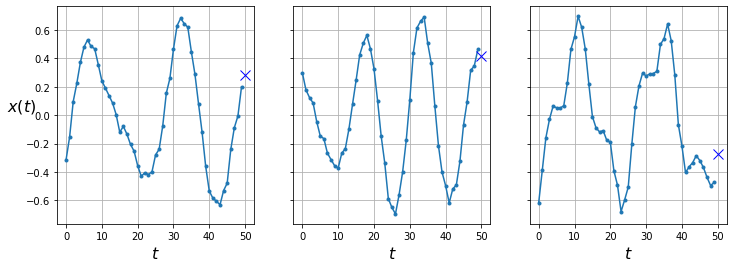

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_test[col, :, 0], y_test[col, 0], y_label=("$x(t)$" if col==0 else None))
plt.show()

We will create the following models on the same dataset:
 - Fully connected network
 - Simple RNN
 - Deep RNN 
 - LSTM
 - GRU

#### Fully connected network

Fully connected network can also handle sequential data by regarding each time point input independently.

In [ ]:
# Why do we need this Flatten layer?
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0790
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 3/10
219/219 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 4/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 5/10
219/219 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 6/10
219/219 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 8/10
219/219 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 10/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0053


In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.004790379665791988

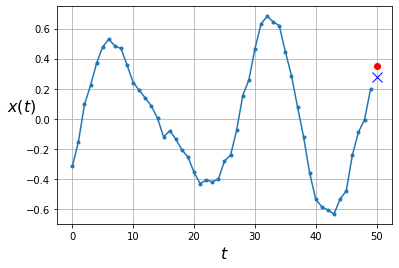

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

#### Vanilla RNN

We can move on to the simplest RNN network having only one hidden state. This does not have any practical value.
- Vanilla RNN is called `SimpleRNN` in keras.
- You do not need to specify the input shape as it will be unrolled based on the time steps (second axis).

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


219/219 [==============================] - 3s 8ms/step - loss: 0.0951
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0358
Epoch 3/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0247
Epoch 4/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0194
Epoch 5/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0164
Epoch 6/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0144
Epoch 7/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0131
Epoch 8/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0123
Epoch 9/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0118
Epoch 10/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0116


In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.01146298460662365

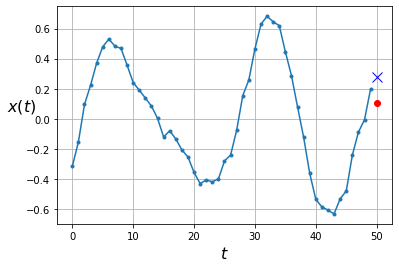

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

#### Deep RNN

We can have more than one RNN layers to let the network learn a bit more complex patterns. Here we have a new important option.
 - `return_sequences`

In [ ]:
# Two SimpleRNN with 20 hidden neurons and return_sequences=True
# Last layer with one simpleRNN with one neuron without return_sequences
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10)

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.0028353268280625343

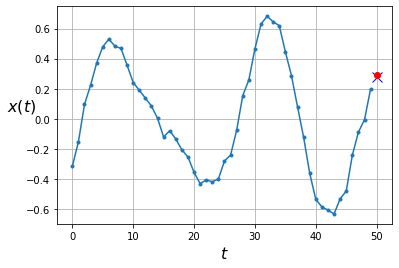

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

#### LSTM & GRU: In practice, these networks work as same as simpleRNN.

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
219/219 [==============================] - 13s 42ms/step - loss: 0.0529
Epoch 2/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0204
Epoch 3/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0108
Epoch 4/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0055
Epoch 5/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0041
Epoch 6/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0034
Epoch 7/10
219/219 [==============================] - 9s 39ms/step - loss: 0.0033
Epoch 8/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0032
Epoch 9/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0030
Epoch 10/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0029


In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.002835119143128395

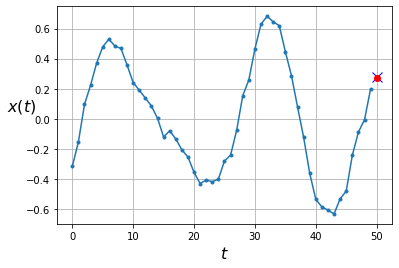

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
219/219 [==============================] - 14s 45ms/step - loss: 0.0366
Epoch 2/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0071
Epoch 3/10
219/219 [==============================] - 9s 43ms/step - loss: 0.0046
Epoch 4/10
219/219 [==============================] - 9s 43ms/step - loss: 0.0043
Epoch 5/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0041
Epoch 6/10
219/219 [==============================] - 9s 43ms/step - loss: 0.0042
Epoch 7/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0040
Epoch 8/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0038
Epoch 9/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0037
Epoch 10/10
219/219 [==============================] - 10s 44ms/step - loss: 0.0036


In [ ]:
model.evaluate(X_test, y_test, verbose=0)

0.003296953160315752

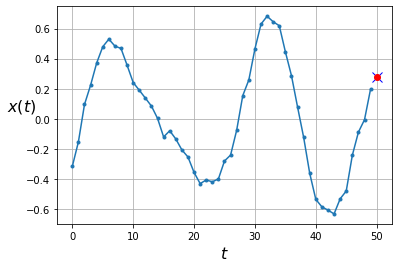

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

#### More than one point?

You can always let model predict more than one point. There can be many ways as follows:
- Let model predict one step ahead and feed it again to the model to predict the next one.
- **Let model predict ten steps all together at the last step.**
- Let model predict ten steps all together at each time step.



In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 22s 83ms/step - loss: 0.0673 - val_loss: 0.0320
Epoch 2/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0246 - val_loss: 0.0194
Epoch 3/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0183 - val_loss: 0.0163
Epoch 4/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0151 - val_loss: 0.0192
Epoch 5/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 6/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 7/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 8/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0116 - val_loss: 0.0132
Epoch 9/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 10/20
219/219 [==============================] - 19s 86ms/step - loss: 0.011

1/1 [==============================] - 0s 360ms/step


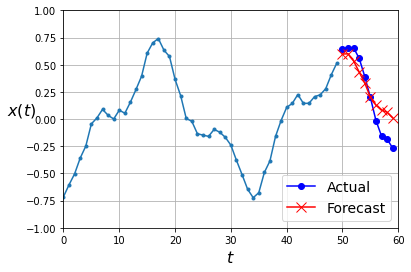

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Task 1: Use another pretrained CNN model on the image dataset

We have tried a pretrained VGG16 model in the lab. Now, you can try to use different pretrained CNN model and see if you can further improve the performance compared to your own CNN model. You can check many different pretrained models on [the Keras website](https://keras.io/api/applications/). Please also note that some of the networks may not work well without `preprocess_input()`. You do not need to fine-tune the pretrained weights but need to create your own input/output layers and train them at least for 10 epochs.

- Here you need to choose any dataset from the tenorflow dataset catalog.
- You should use at least **two** Tensorflow callbacks when you fit your model. These can be built-in ones or your personalized callback.
- You should use Tensorflow's data API (`tf.data`) to manage your dataset and use `shuffle`, `batch`, and `prefetch` functions.
- Compare the result in terms of the test accuracy from `VGG16` model and your new chosen model.

### Task 2: Time series classification using CNN or RNN

We have used RNN networks for time series forecasting problem. Those models can also be easily used for time series classification with different output layers, activation functions, and error functions. Here we will use one famous dataset called **FordA**. 

One more interesting thing we can try is to use the CNN network instead of RNN to catch some patterns for the classification task. Since time series only have one dimension, we may need to use 1D-CNN. Of course we can always start from the traditional fully connected network as well. We can even merge CNN and RNN - the easiest way is to apply CNNs first and feed the output to any RNN network.
 - [keras.layers.Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/)

Try four different models: 1) Fully connected network, 2) RNN only (any variant), 3) 1D-CNN only, and 4) 1D-CNN + RNN. You can freely construct any structure you want. Report the best model in terms of **accuracy** on the test set among four. There is no definitive answer and it is up to your own model. Here you need to keep the following rules:

- You should use at least **two** Tensorflow callbacks when you fit your model. These can be built-in ones or your personalized callback.
- You should use Tensorflow's data API (`tf.data`) to manage your dataset and use `shuffle`, `batch`, and `prefetch` functions. This means that you need to convert the data format using the `from_tensor_slices` function.
- You need to validate your model for each epoch. You should create your validation set using `tf.Data` methods.
- You need to clearly plot the test accuracy of the four models.
- For the 1D-CNN+RNN network, you do not need to apply any pooling layer.


In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")